# Run Modes

Running MAGICC in different modes can be non-trivial. In this notebook we show how to set MAGICC's config flags so that it will run as desired for a few different cases.

In [1]:
# NBVAL_IGNORE_OUTPUT
from os.path import join
import datetime
import dateutil


import numpy as np
import pandas as pd


from pymagicc import MAGICC6, rcp26, zero_emissions
from pymagicc.io import MAGICCData

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

## Concentration to emissions hybrid

This is MAGICC's default run mode. In this run mode, MAGICC will run with prescribed concentrations (or a quantity which scales linearly with radiative forcing for aerosol species) until a given point in time and will then switch to running in emissions driven mode.

In [3]:
with MAGICC6() as magicc:
    res = magicc.run(rcp26)

In [4]:
# NBVAL_IGNORE_OUTPUT
res.head()

,model,scenario,region,variable,unit,time,climate_model,todo,value
0,IMAGE,RCP26,World,Emissions|BC|MAGICC Fossil and Industrial,Mt BC / yr,1765-07-12,MAGICC6,N/A,0.0
1,IMAGE,RCP26,World|Northern Hemisphere|Land,Emissions|BC|MAGICC Fossil and Industrial,Mt BC / yr,1765-07-12,MAGICC6,N/A,0.0
2,IMAGE,RCP26,World|Northern Hemisphere|Ocean,Emissions|BC|MAGICC Fossil and Industrial,Mt BC / yr,1765-07-12,MAGICC6,N/A,0.0
3,IMAGE,RCP26,World|Southern Hemisphere|Land,Emissions|BC|MAGICC Fossil and Industrial,Mt BC / yr,1765-07-12,MAGICC6,N/A,0.0
4,IMAGE,RCP26,World|Southern Hemisphere|Ocean,Emissions|BC|MAGICC Fossil and Industrial,Mt BC / yr,1765-07-12,MAGICC6,N/A,0.0


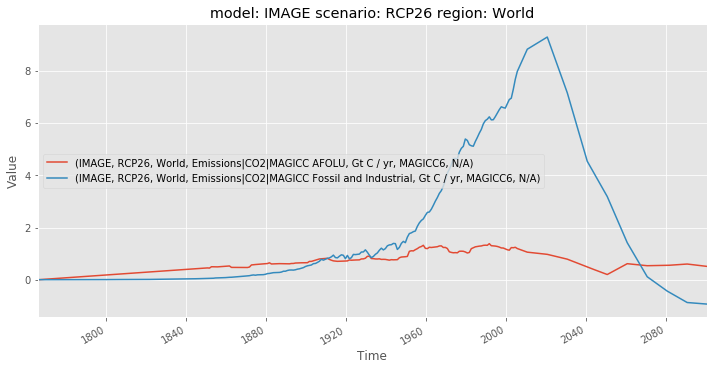

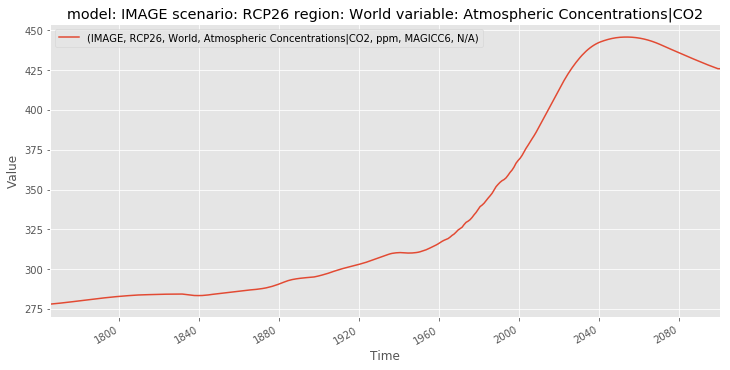

In [5]:
res.filter(
    variable="Emis*CO2*",
    region="World"
).line_plot(x="time");
res.filter(
    variable="Atmos*Conc*CO2",
    region="World"
).line_plot(x="time");

The switches which control the time at which MAGICC switches from concentrations driven to emissions driven are all in the form `GAS_SWITCHFROMXXX2EMIS_YEAR` e.g. `CO2_SWITCHFROMCONC2EMIS_YEAR` and `BCOC_SWITCHFROMRF2EMIS_YEAR`. 

Changing the value of these switches will alter how MAGICC runs.

In [6]:
df = rcp26.data.copy()
df["scenario"] = df["scenario"].apply(lambda x: "{}_alter_co2_conc2emis".format(x))
with MAGICC6() as magicc:
    res.append(magicc.run(
        MAGICCData(df), 
        co2_switchfromconc2emis_year=1850
    ))

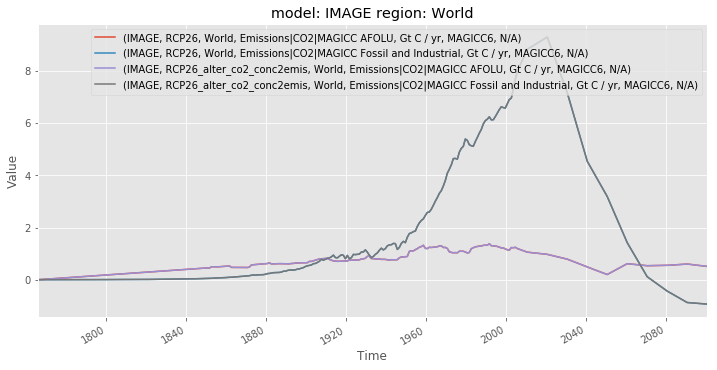

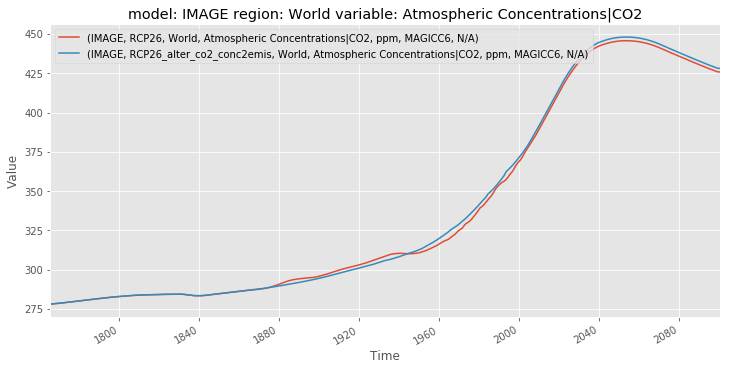

In [7]:
res.filter(
    variable="Emis*CO2*",
    region="World"
).line_plot(x="time");
res.filter(
    variable="Atmos*Conc*CO2",
    region="World"
).line_plot(x="time");

As we can see, the emissions remain unchanged but the concentrations are altered as MAGICC is now running emissions driven from 1850 rather than 2005 (the default).

To get a fully emissions driven run, you need to change all of the relevant `GAS_SWITCHXXX2EMIS_YEAR` flags.

## CO$_2$ Emissions Driven Only

We can get a CO$_2$ emissions only driven run like shown.

INFO:root:>=13 labels, not applying legend


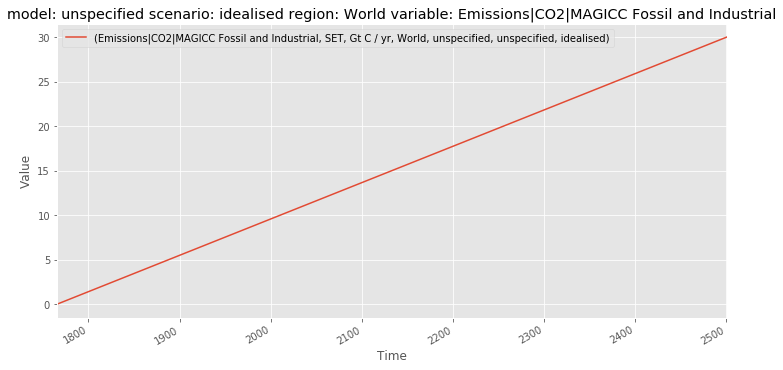

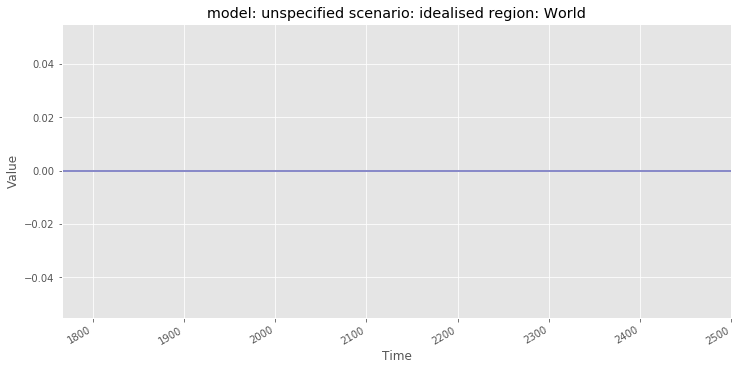

In [8]:
df = zero_emissions.data.copy()
df.loc[
    df["variable"] == "Emissions|CO2|MAGICC Fossil and Industrial",
    "value"
] = np.linspace(0, 30, len(df["time"].unique()))
scen = MAGICCData(df)
scen.filter(variable="Em*CO2*Fossil*").line_plot(x="time")
scen.filter(variable="Em*CO2*Fossil*", keep=False).line_plot(x="time");

In [9]:
with MAGICC6() as magicc:
    co2_only_res = magicc.run(
        scen,
        endyear=scen["time"].max().year,
        rf_total_constantafteryr=5000,
        rf_total_runmodus="CO2",
        co2_switchfromconc2emis_year=min(scen["time"]).year,
    )

Ignoring input data which is not required for .SCEN file


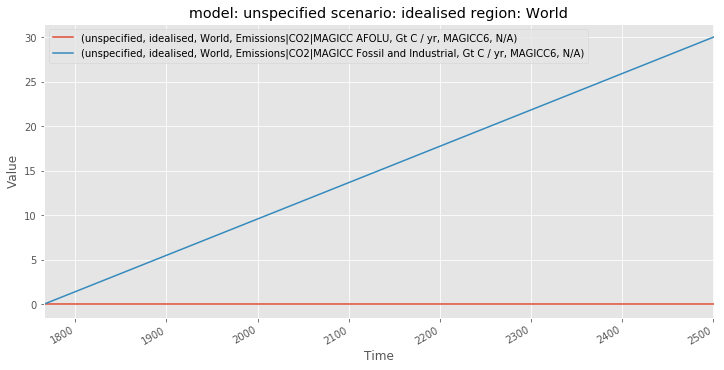

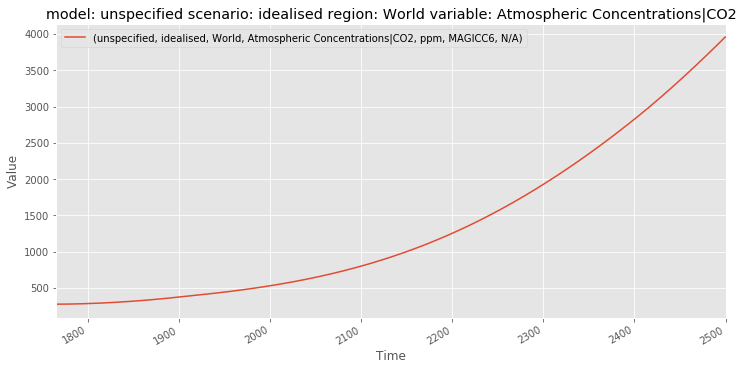

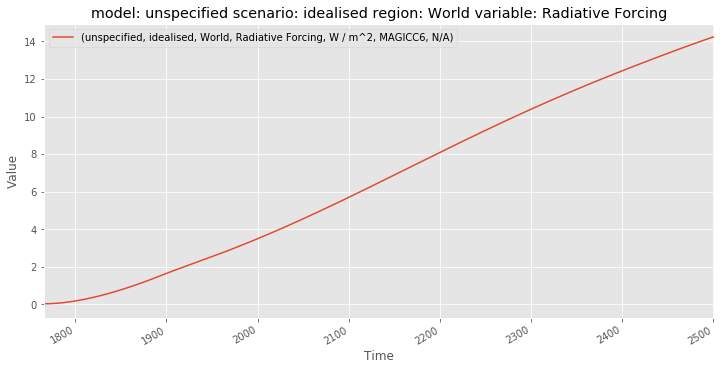

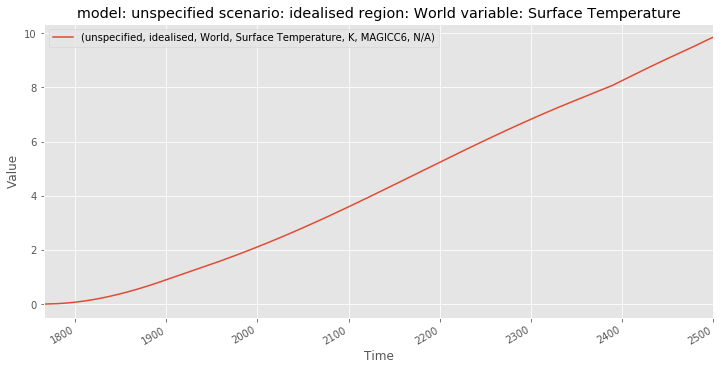

In [10]:
co2_only_res.filter(
    variable="Emis*CO2*",
    region="World"
).line_plot(x="time")
co2_only_res.filter(
    variable="Atmos*Conc*CO2",
    region="World"
).line_plot(x="time")
co2_only_res.filter(
    variable="Radiative Forcing",
    region="World"
).line_plot(x="time")
co2_only_res.filter(
    variable="Surface Temperature",
    region="World"
).line_plot(x="time");

## Prescribed Forcing Driven Only

It is also possible to examine MAGICC's response to a prescribed radiative forcing only.

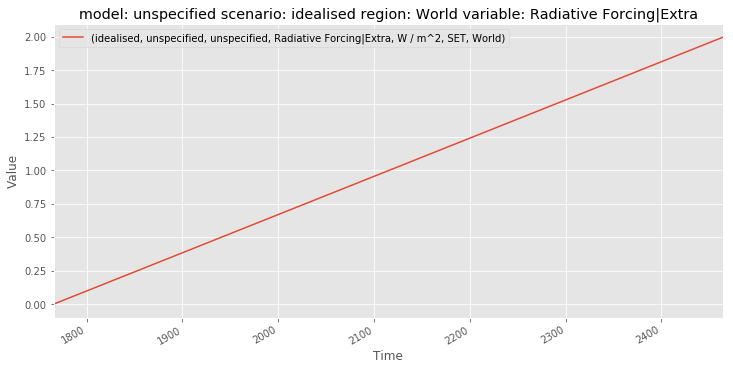

In [11]:
time = [
    datetime.datetime(1765, 7, 12) + i*dateutil.relativedelta.relativedelta(years=1) 
    for i in range(700)
]

forcing_external = 2.0 * np.arange(0, len(time)) / len(time)
forcing_external_df = pd.DataFrame({
    "time": time,
    "scenario": "idealised",
    "model": "unspecified",
    "climate_model": "unspecified",
    "variable": "Radiative Forcing|Extra",
    "unit": "W / m^2",
    "todo": "SET",
    "region": "World",
    "value": forcing_external
})
forcing_ext = MAGICCData(forcing_external_df)
forcing_ext.metadata = {"header": "External radiative forcing with linear increase"}
forcing_ext.line_plot(x="time");

In [12]:
with MAGICC6() as magicc:
    forcing_ext_filename = "EXTERNAL_RF.IN"
    forcing_ext.write(
        join(magicc.run_dir, forcing_ext_filename), 
        magicc.version
    )
    ext_forc_only_res = magicc.run(
        rf_extra_read=1,
        file_extra_rf=forcing_ext_filename,
        rf_total_runmodus="QEXTRA",
        endyear=max(time).year,  
        rf_initialization_method="ZEROSTARTSHIFT",  # this is default but to be sure
        rf_total_constantafteryr=5000,
    )

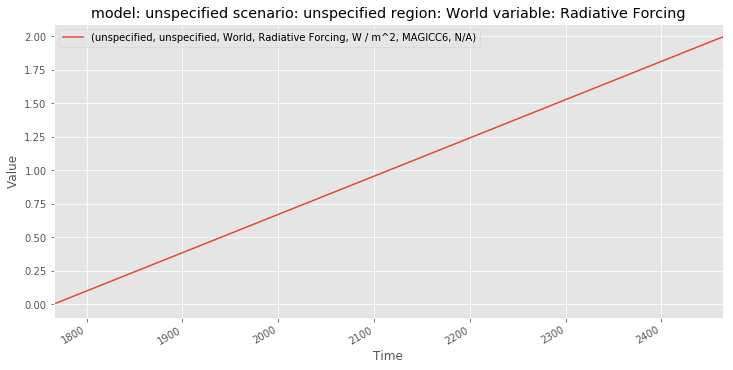

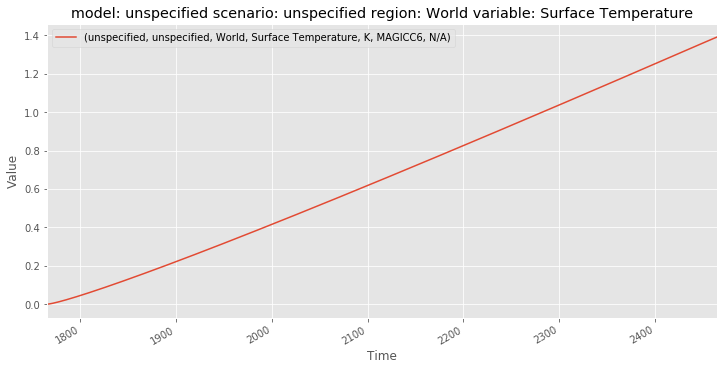

In [13]:
ext_forc_only_res.filter(
    variable="Radiative Forcing",
    region="World"
).line_plot(x="time")
ext_forc_only_res.filter(
    variable="Surface Temperature",
    region="World"
).line_plot(x="time");

## Zero Temperature Output

Getting MAGICC to return zero for its temperature output is surprisingly difficult. To help address this, we add the `set_zero_config` method to our MAGICC classes.

In [14]:
print(MAGICC6.set_zero_config.__doc__)

Set config such that radiative forcing and temperature output will be zero
        
        This method is intended as a convenience only, it does not handle everything in 
        an obvious way. Adjusting the parameter settings still requires great care and
        may behave unepexctedly.
        


In [15]:
with MAGICC6() as magicc:
    magicc.set_zero_config()
    res_zero = magicc.run()

Ignoring input data which is not required for .SCEN file


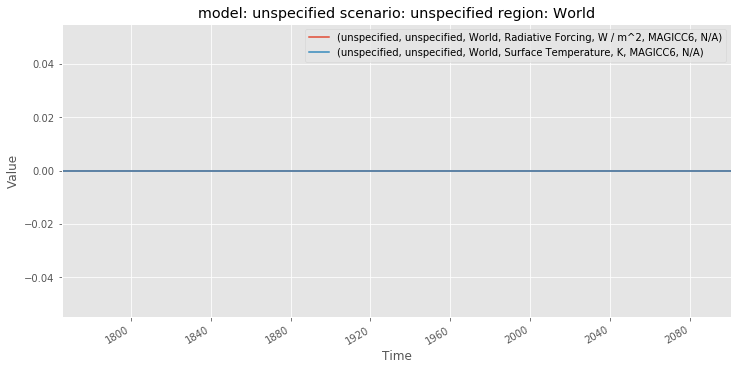

In [16]:
res_zero.filter(
    variable=[
        "Surface Temperature",
        "Radiative Forcing"
    ],
    region="World"
).line_plot(x="time");

## CO$_2$ Emissions and Prescribed Forcing

It is also possible to run MAGICC in a mode which is CO$_2$ emissions driven but also includes a prescribed external forcing.

INFO:root:>=13 labels, not applying legend


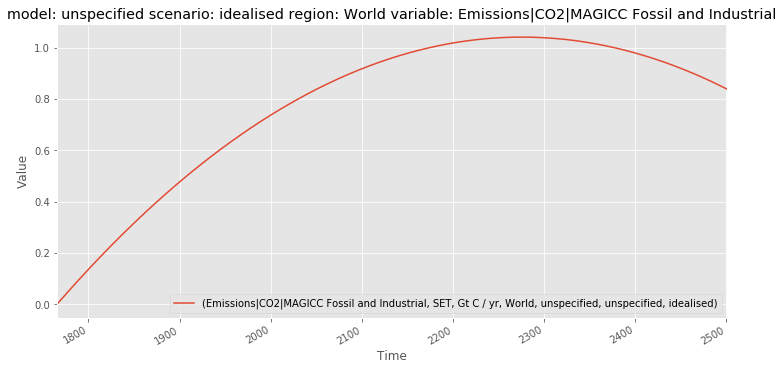

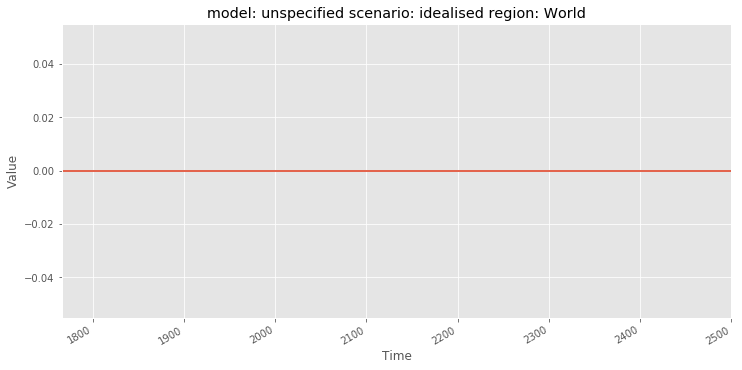

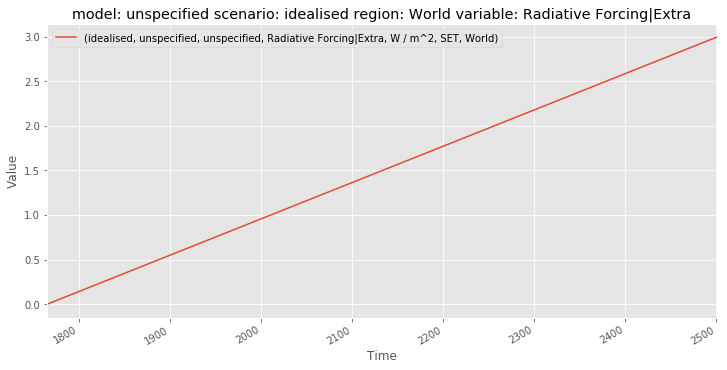

In [28]:
df = zero_emissions.data.copy()
time = df["time"].unique()
emms_fossil_co2 = (
    np.linspace(0, 3, len(time))
    - (1 + (np.arange(len(time)) - 500) / 500)**2
)
df.loc[
    df["variable"] == "Emissions|CO2|MAGICC Fossil and Industrial",
    "value"
] = emms_fossil_co2
scen = MAGICCData(df)
scen.filter(variable="Em*CO2*Fossil*").line_plot(x="time")
scen.filter(variable="Em*CO2*Fossil*", keep=False).line_plot(x="time")

forcing_external = 3.0 * np.arange(0, len(time)) / len(time)
forcing_external_df = pd.DataFrame({
    "time": time,
    "scenario": "idealised",
    "model": "unspecified",
    "climate_model": "unspecified",
    "variable": "Radiative Forcing|Extra",
    "unit": "W / m^2",
    "todo": "SET",
    "region": "World",
    "value": forcing_external
})
forcing_ext = MAGICCData(forcing_external_df)
forcing_ext.metadata = {"header": "External radiative forcing with linear increase"}
forcing_ext.line_plot(x="time");

In [29]:
with MAGICC6() as magicc:
    magicc.set_zero_config()  # very important, try commenting this out and see what happens
    forcing_ext_filename = "EXTERNAL_RF.IN"
    forcing_ext.write(
        join(magicc.run_dir, forcing_ext_filename), 
        magicc.version
    )
    co2_emms_ext_forc_res = magicc.run(
        scen,
        endyear=scen["time"].max().year,
        co2_switchfromconc2emis_year=min(scen["time"]).year,
        rf_extra_read=1,
        file_extra_rf=forcing_ext_filename,
        rf_total_runmodus="ALL",  # default but just in case
        rf_initialization_method="ZEROSTARTSHIFT",  # this is default but to be sure 
        rf_total_constantafteryr=5000,
    )

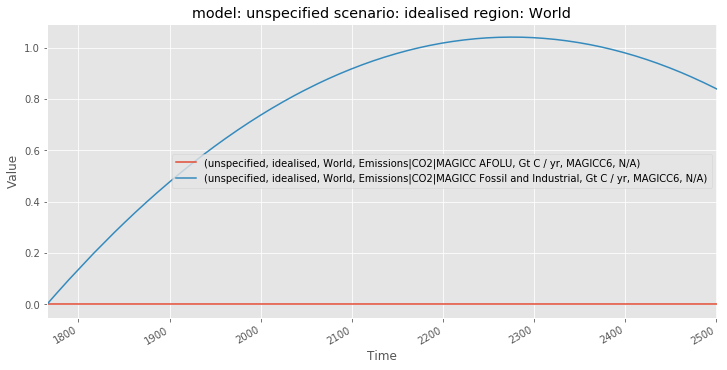

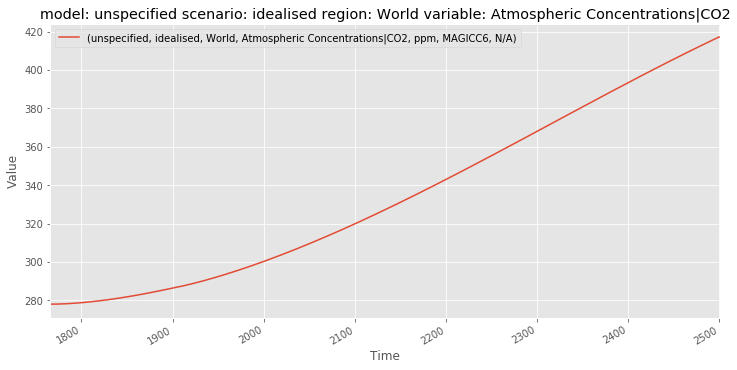

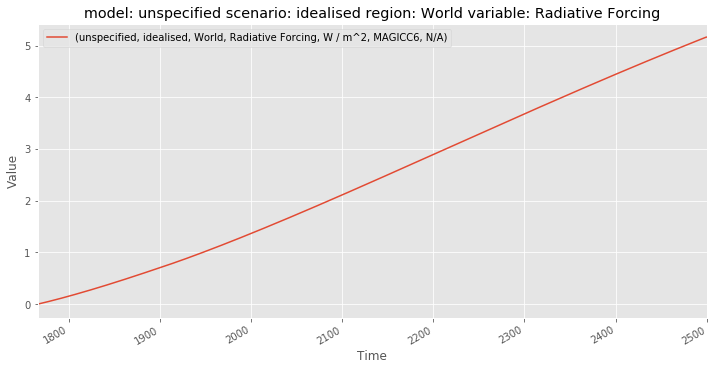

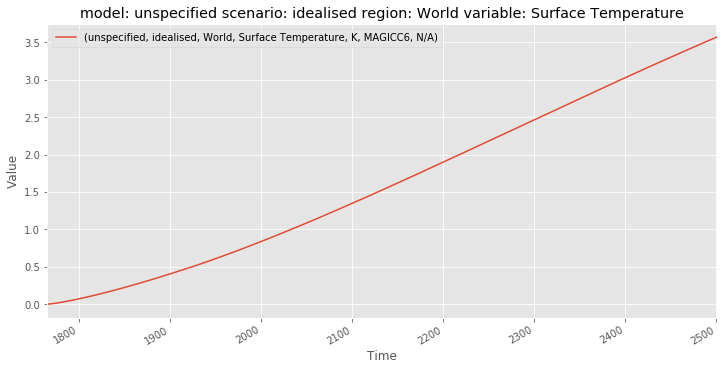

In [30]:
co2_emms_ext_forc_res.filter(
    variable="Emis*CO2*",
    region="World"
).line_plot(x="time")
co2_emms_ext_forc_res.filter(
    variable="Atmos*Conc*CO2",
    region="World"
).line_plot(x="time")
co2_emms_ext_forc_res.filter(
    variable="Radiative Forcing",
    region="World"
).line_plot(x="time")
co2_emms_ext_forc_res.filter(
    variable="Surface Temperature",
    region="World"
).line_plot(x="time");

If we adjust MAGICC's CO$_2$ temperature feedback start year, it is easier to see what is going on.

In [31]:
with MAGICC6() as magicc:
    for temp_feedback_year in [2000, 2100, 3000]:
        df = scen.data.copy()
        df["scenario"] = df["scenario"].apply(lambda x: "{}_{}_CO2_temperature_feedback".format(x, temp_feedback_year))
        magicc.set_zero_config()  
        forcing_ext_filename = "EXTERNAL_RF.IN"
        forcing_ext.write(
            join(magicc.run_dir, forcing_ext_filename), 
            magicc.version
        )
        co2_emms_ext_forc_res.append(magicc.run(
            MAGICCData(df),
            endyear=scen["time"].max().year,
            co2_switchfromconc2emis_year=min(scen["time"]).year,
            rf_extra_read=1,
            file_extra_rf=forcing_ext_filename,
            rf_total_runmodus="ALL", 
            rf_initialization_method="ZEROSTARTSHIFT",
            rf_total_constantafteryr=5000,
            co2_tempfeedback_yrstart=temp_feedback_year, 
        ))

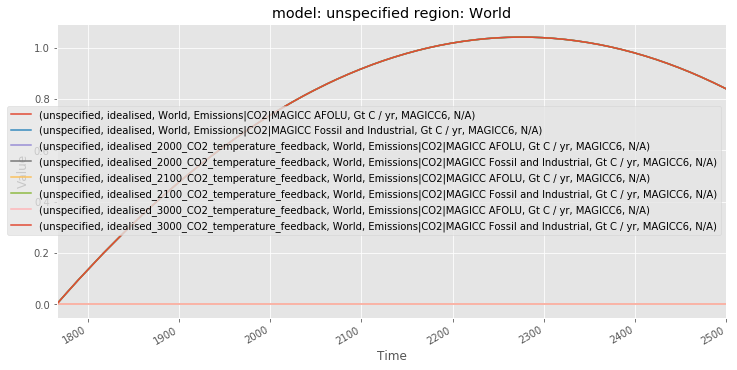

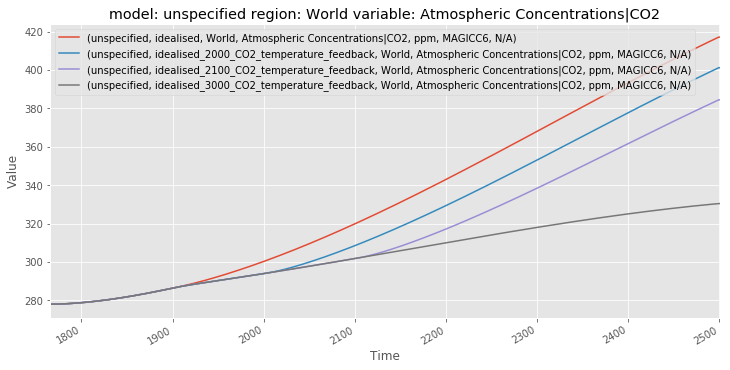

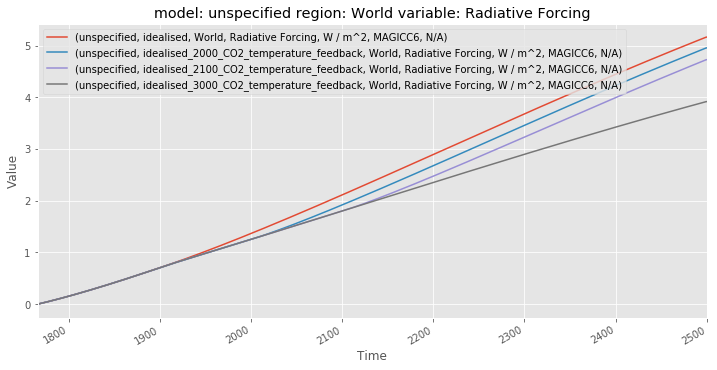

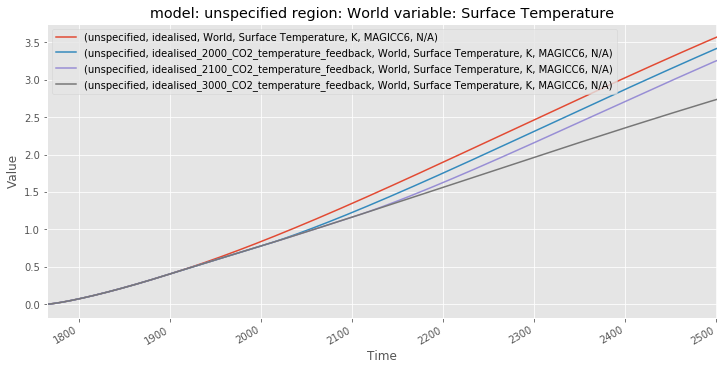

In [32]:
co2_emms_ext_forc_res.filter(
    variable="Emis*CO2*",
    region="World"
).line_plot(x="time")
co2_emms_ext_forc_res.filter(
    variable="Atmos*Conc*CO2",
    region="World"
).line_plot(x="time")
co2_emms_ext_forc_res.filter(
    variable="Radiative Forcing",
    region="World"
).line_plot(x="time")
co2_emms_ext_forc_res.filter(
    variable="Surface Temperature",
    region="World"
).line_plot(x="time");